### Downloading the data

In [2]:
import os

if not os.path.exists("gtzan-dataset-music-genre-classification.zip"):
    !kaggle datasets download -d "andradaolteanu/gtzan-dataset-music-genre-classification"
    !unzip "gtzan-dataset-music-genre-classification.zip"

### Creating the datasets

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
import librosa

In [116]:
class AudioTransforms:
    def __init__(self):
        self.transforms = [
            self.add_noise,
            self.change_pitch,
            self.time_masking,
            self.time_shift,
            self.change_volume
        ]
        
    def apply_random_transforms(self, y):
        y = y.copy()
        for transform in self.transforms:
            if random.random() > 0.5:
                y = transform(y)
        return y
    
    def add_noise(self, y, noise_factor=0.005):
        noise = np.random.randn(len(y))
        y = y + noise_factor * noise
        return y
    
    def change_pitch(self, y, pitch_factor=0.5):
        y = librosa.effects.pitch_shift(y, sr=22050, n_steps=pitch_factor * 2 - 1)
        return y
    
    def time_masking(self, y, mask_factor=0.05):
        y = y.copy()
        mask_length = int(len(y) * mask_factor)
        start = np.random.randint(0, len(y) - mask_length)
        y[start : start + mask_length] = 0
        return y
    
    def time_shift(self, y, shift_max=0.2):
        shift = int(len(y) * np.random.uniform(-shift_max, shift_max))
        y = np.roll(y, shift)
        return y

    def change_volume(self, y, volume_factor=0.5):
        y = y * volume_factor
        return y

In [117]:
def audio_to_spectrogram(audio_path, duration=30, audio_transform=False):
    # Load audio
    y, sr = librosa.load(audio_path, duration=duration)
    
    if audio_transform:
        tranformation = AudioTransforms()
        y = tranformation.apply_random_transforms(y)

    # Convert to Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
    
    # Convert to RGB-like format (single channel)
    mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())  # Normalize to [0, 1]
    mel_spec = (mel_spec * 255.0).astype(np.uint8)  # Convert to 8-bit
    
    # Convert to PIL Image
    mel_spec = Image.fromarray(mel_spec)
    return mel_spec

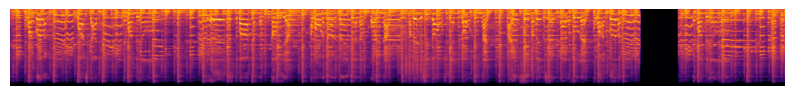

(1292, 128)


In [118]:
# Display a random spectrogram
audio_path = "Data/genres_original/blues/blues.00000.wav"
spectrogram = audio_to_spectrogram(audio_path, duration=30, audio_transform=True)
plt.figure(figsize=(10, 5))
plt.imshow(spectrogram, cmap="inferno")
plt.axis("off")
plt.show()

# Print the shape of the spectrogram
print(spectrogram.size)

In [105]:
class AudioDataset(Dataset):
    def __init__(self, audio_dir, transform=None, audio_transform=False):
        self.audio_dir = audio_dir
        self.transform = transform
        self.audio_files = []
        self.labels = []
        self.genres = sorted(os.listdir(audio_dir))  # Genre names as class labels
        
        # Collect all audio files and their labels
        for label, genre in enumerate(self.genres):
            genre_path = os.path.join(audio_dir, genre)
            for file in os.listdir(genre_path):
                if file.endswith(".wav"):  # Only process .wav files
                    self.audio_files.append(os.path.join(genre_path, file))
                    self.labels.append(label)
        
        self.audio_transform = audio_transform
                    
    def __len__(self):
        return len(self.audio_files)
    
    def __getitem__(self, idx):
        audio_path = self.audio_files[idx]
        label = self.labels[idx]
        
        # Convert audio to spectrogram
        spectrogram = audio_to_spectrogram(audio_path, audio_transform=self.audio_transform)
        
        # Apply transforms
        if self.transform:
            spectrogram = self.transform(spectrogram)
            
        return spectrogram, label, audio_path

In [106]:
# Transform to apply to the data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

# Create dataset
audio_dir = 'Data/genres_original'
audio_dataset = AudioDataset(audio_dir, transform=transform, audio_transform=False)

# Split dataset into train and test
train_idx, test_idx = train_test_split(range(len(audio_dataset)), test_size=0.2, stratify=audio_dataset.labels, random_state=42)

# Create subsets
train_dataset = Subset(audio_dataset, train_idx)
test_dataset = Subset(audio_dataset, test_idx)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

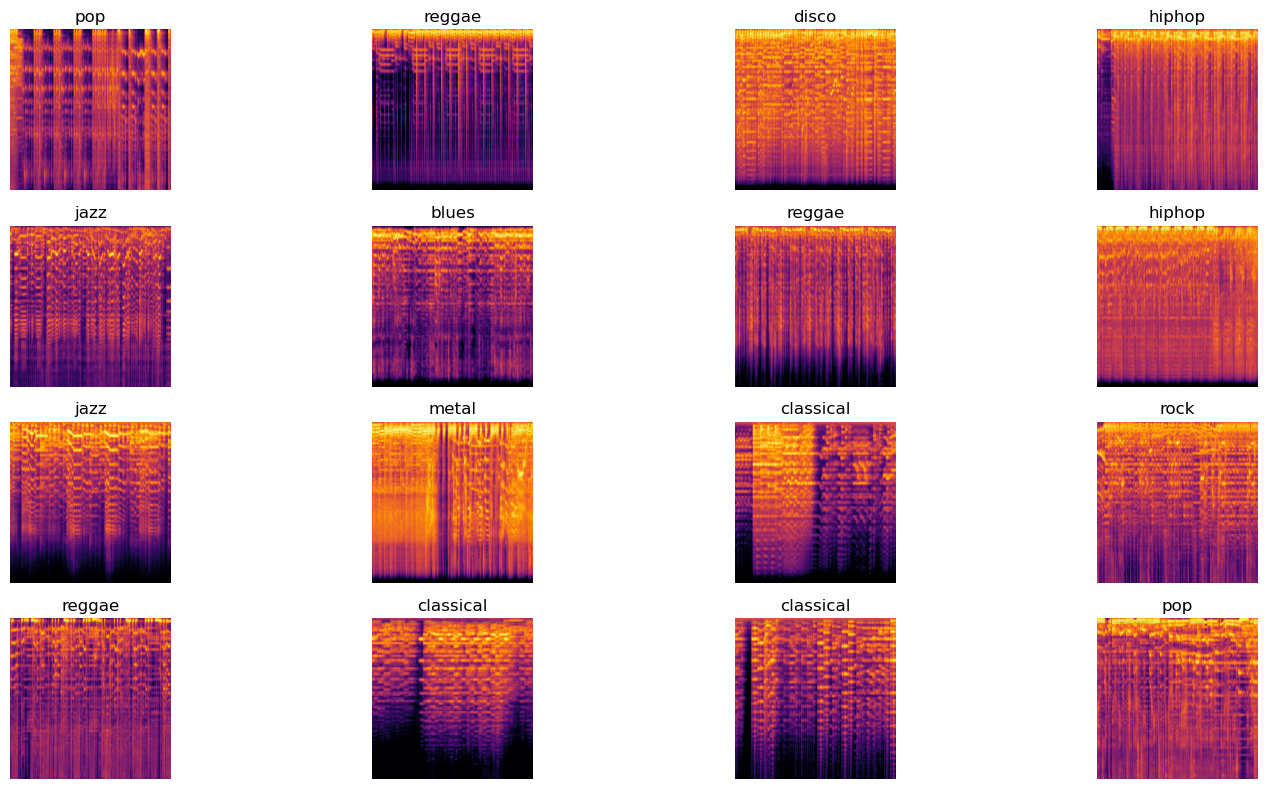

torch.Size([32, 1, 224, 224])


In [ ]:
# Display a batch of data
spectrogram, label, audio_path = next(iter(train_loader))
plt.figure(figsize=(16, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(spectrogram[i, 0], cmap="inferno")
    plt.title(audio_dataset.genres[label[i]])
    plt.axis("off")
plt.tight_layout()
plt.show()